# **Model:**

In [ ]:
!pip install opendatasets
import numpy as np
import pandas as pd
import opendatasets as od


In [ ]:
# Assign the Kaggle data set URL into variable
dataset = 'https://www.kaggle.com/datasets/techsash/waste-classification-data'
# Using opendatasets let's download the data sets
od.download(dataset)

Skipping, found downloaded files in "./waste-classification-data" (use force=True to force download)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import tensorflow
import tqdm
import glob

from tqdm import tqdm

from skimage.io import imread, imshow
# from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix
import seaborn as sns

%matplotlib inline

In [ ]:
train_path = "/content/waste-classification-data/DATASET/TRAIN"
test_path = "/content/waste-classification-data/DATASET/TEST"

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from glob import glob
import cv2

In [ ]:
x_data = []
y_data = []

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split("/")[-1])

data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 12565/12565 [00:09<00:00, 1271.23it/s]


In [ ]:
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class: ",numberOfClass)

Number Of Class:  2


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    zoom_range=0.2,
    rotation_range=10,
    horizontal_flip=True,
    shear_range=0.2,
    validation_split=0.2
)

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(100, 100),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

Found 4512 images belonging to 2 classes.


In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/waste-classification-data/DATASET/TRAIN',
                                                   target_size = (100,100),
                                                   class_mode = 'binary',
                                                   batch_size = 128,
                                                   subset = 'training')

Found 18052 images belonging to 2 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/waste-classification-data/DATASET/TRAIN',
                                                  target_size = (100,100),
                                                  class_mode = 'binary',
                                                  batch_size = 128,
                                                  subset = 'validation')

Found 4512 images belonging to 2 classes.


In [ ]:
base_model = VGG16(input_shape=(100,100,3),
                   include_top=False,
                   weights="imagenet")

In [ ]:
base_model.trainable = True

In [ ]:
for layer in base_model.layers:
    layer.trainable=False

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, BatchNormalization, Dense, Activation
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())

# adding L2
model.add(Dense(512, kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(256, kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (Batch  (None, 25088)             100352    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              4096      
 chNormalization)                                       

In [ ]:
# Model Compile
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
             # learning_rate=0.001,
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])


In [ ]:
filepath = './model.h5'

earlystopping = EarlyStopping(monitor = 'val_accuracy',
                              mode = 'max' ,
                              patience = 5,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_accuracy',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)

callback_list = [earlystopping, checkpoint]

In [ ]:
model_history=model.fit(train_dataset,
                        validation_data=validation_generator,
                        epochs = 10,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/10
142/142 [==============================] - ETA: 0s - loss: 14.1960 - accuracy: 0.8755 - precision: 0.8453 - recall: 0.8802
Epoch 1: val_accuracy improved from -inf to 0.88763, saving model to ./model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


142/142 [==============================] - 71s 454ms/step - loss: 14.1960 - accuracy: 0.8755 - precision: 0.8453 - recall: 0.8802 - val_loss: 11.0537 - val_accuracy: 0.8876 - val_precision: 0.8569 - val_recall: 0.8959
Epoch 2/10
142/142 [==============================] - ETA: 0s - loss: 9.0718 - accuracy: 0.8895 - precision: 0.8706 - recall: 0.8816
Epoch 2: val_accuracy did not improve from 0.88763
142/142 [==============================] - 64s 451ms/step - loss: 9.0718 - accuracy: 0.8895 - precision: 0.8706 - recall: 0.8816 - val_loss: 7.5332 - val_accuracy: 0.8568 - val_precision: 0.7760 - val_recall: 0.9515
Epoch 3/10
142/142 [==============================] - ETA: 0s - loss: 6.3565 - accuracy: 0.8953 - precision: 0.8812 - recall: 0.8827
Epoch 3: val_accuracy did not improve from 0.88763
142/142 [==============================] - 64s 453ms/step - loss: 6.3565 - accuracy: 0.8953 - precision: 0.8812 - recall: 0.8827 - val_loss: 5.4576 - val_accuracy: 0.8590 - val_precision: 0.7749 - v

In [ ]:
results = model.evaluate(valid_dataset)
print(f"Accuracy: {results[1]*100:.2f}%")
print(f"Precision: {results[2]*100:.2f}%")
print(f"Recall: {results[3]*100:.2f}%")
f1_score = 2 * (results[2] * results[3]) / (results[2] + results[3])
print(f"F1-Score: {f1_score*100:.2f}")

36/36 [==============================] - 3s 93ms/step - loss: 1.0494 - accuracy: 0.9047 - precision: 0.8577 - recall: 0.9410
Accuracy: 90.47%
Precision: 85.77%
Recall: 94.10%
F1-Score: 89.74


In [ ]:
# Test Data
test_data = test_datagen.flow_from_directory(directory = '/content/waste-classification-data/DATASET/TEST',
                                             target_size = (100,100),
                                             class_mode = 'binary',
                                             batch_size = 128)

Found 2513 images belonging to 2 classes.


In [ ]:
results = model.evaluate(test_data)
print(f"Accuracy: {results[1]*100:.2f}%")
print(f"Precision: {results[2]*100:.2f}%")
print(f"Recall: {results[3]*100:.2f}%")
f1_score = 2 * (results[2] * results[3]) / (results[2] + results[3])
print(f"F1-Score: {f1_score*100:.2f}")

20/20 [==============================] - 2s 97ms/step - loss: 1.0257 - accuracy: 0.9204 - precision: 0.9161 - recall: 0.9029
Accuracy: 92.04%
Precision: 91.61%
Recall: 90.29%
F1-Score: 90.94


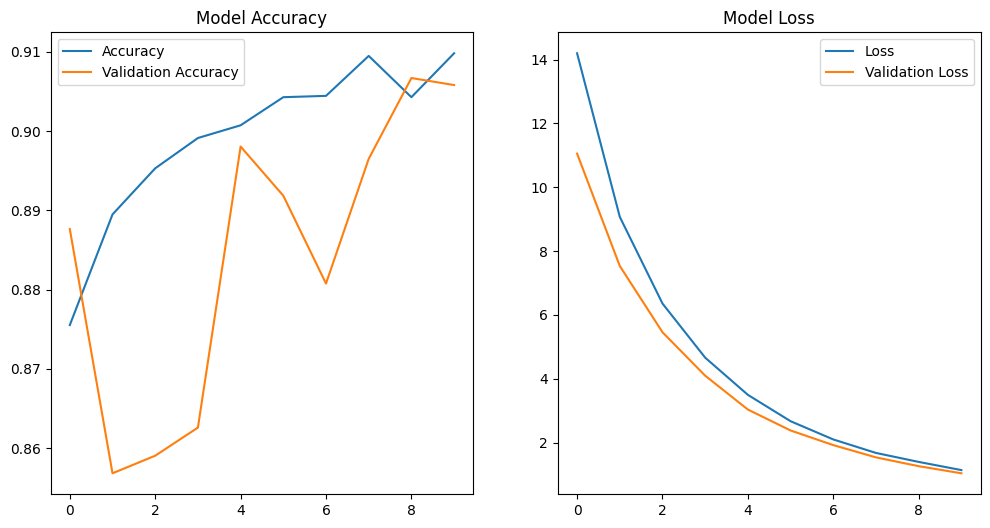

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model_history.history['accuracy'], label='Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'], label='Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_data)

20/20 [==============================] - 4s 217ms/step - loss: 2783.7930 - accuracy: 0.8380 - precision: 0.8676 - recall: 0.7482


[2783.79296875, 0.8380421996116638, 0.8675704002380371, 0.7482014298439026]

In [ ]:
model.save('VGG_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

def vgg_hpt_predict_func(img_path):
  #img_path = '/content/test4.jpg'
  img = load_img(img_path, target_size=(100, 100))
  img_array = img_to_array(img)
  img_array_rescaled = img_array / 255.0

  plt.imshow(img_array_rescaled)
  plt.axis('off')

  img_array_expanded = np.expand_dims(img_array_rescaled, axis=0)

  prediction = model.predict(img_array_expanded)
  print("Prediction:", prediction[0])

  if prediction[0][0] > 0.5:
      print("\033[94m"+"This image -> Recyclable"+"\033[0m")
  else:
      print("\033[91m"+"This image -> Organic"+"\033[0m")

  plt.show()

1/1 [==============================] - 0s 28ms/step
Prediction: [0.983426]
This image -> Recyclable


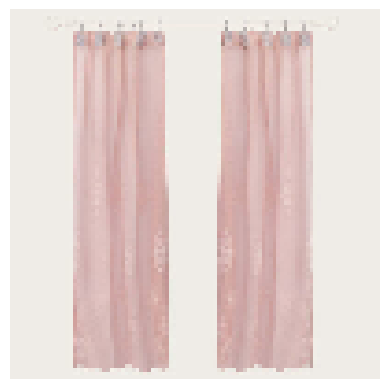

In [ ]:
#test_img = cv2.imread("/content/test2.jpg")
vgg_hpt_predict_func("/content/test2.jpg")

1/1 [==============================] - 0s 27ms/step
Prediction: [0.00374771]
This image -> Organic


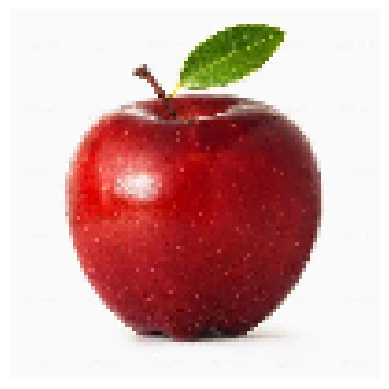

In [ ]:
vgg_hpt_predict_func("/content/test4.jpg")

1/1 [==============================] - 0s 27ms/step
Prediction: [0.9565833]
This image -> Recyclable


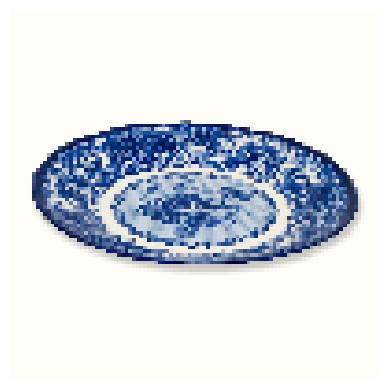

In [ ]:
vgg_hpt_predict_func("/content/test3.jpg")

1/1 [==============================] - 0s 28ms/step
Prediction: [0.01695183]
This image -> Organic


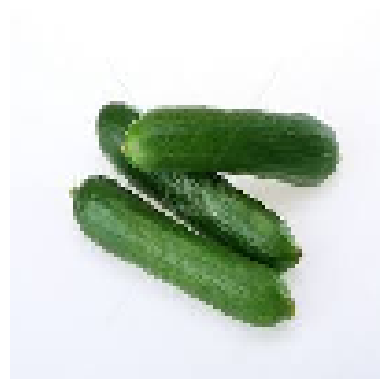

In [ ]:
vgg_hpt_predict_func("/content/test1.jpeg")

In [ ]:
model.save('VGG_HT_model_New.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Download Model**

In [139]:
from tensorflow.keras.models import load_model
VGG_model = load_model("/content/VGG_model.h5")

In [140]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

def vgg_hpt_predict_func(img_path, model):
  img = load_img(img_path, target_size=(100, 100))
  img_array = img_to_array(img)
  img_array_rescaled = img_array / 255.0

  plt.imshow(img_array_rescaled)
  plt.axis('off')

  img_array_expanded = np.expand_dims(img_array_rescaled, axis=0)

  prediction = model.predict(img_array_expanded)
  print("Prediction:", prediction[0])

  if prediction[0][0] > 0.5:
      print("\033[94m"+"This image -> Recyclable"+"\033[0m")
  else:
      print("\033[91m"+"This image -> Organic"+"\033[0m")

  plt.show()

1/1 [==============================] - 0s 239ms/step
Prediction: [0.983426]
This image -> Recyclable


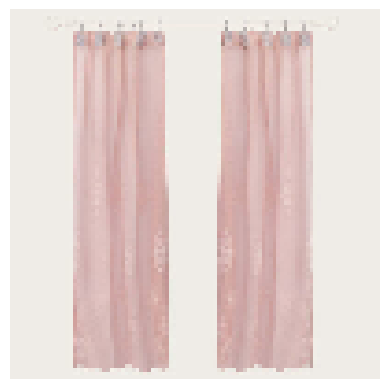

In [141]:
vgg_hpt_predict_func("/content/test2.jpg", VGG_model)

1/1 [==============================] - 0s 25ms/step
Prediction: [0.9565833]
This image -> Recyclable


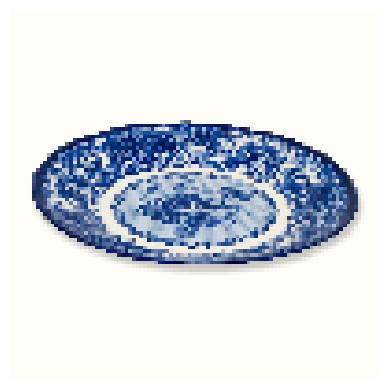

In [142]:
vgg_hpt_predict_func("/content/test3.jpg", VGG_model)

1/1 [==============================] - 0s 23ms/step
Prediction: [0.00374771]
This image -> Organic


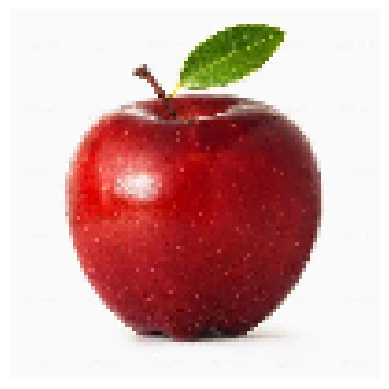

In [143]:
vgg_hpt_predict_func("/content/test4.jpg", VGG_model)

1/1 [==============================] - 0s 26ms/step
Prediction: [0.08980748]
This image -> Organic


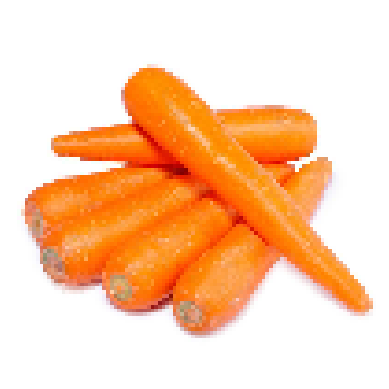

In [145]:
vgg_hpt_predict_func("/content/test5.jpeg", VGG_model)

In [146]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Live Evaluate**

1/1 [==============================] - 0s 27ms/step
Prediction: [0.9260961]
This image -> Recyclable


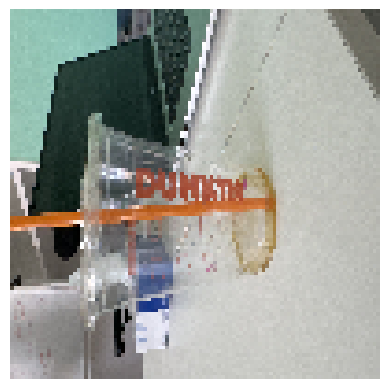

In [147]:
vgg_hpt_predict_func("/content/drive/MyDrive/load_image_test_model/IMG_2565.JPG", VGG_model)

1/1 [==============================] - 0s 25ms/step
Prediction: [0.9512673]
This image -> Recyclable


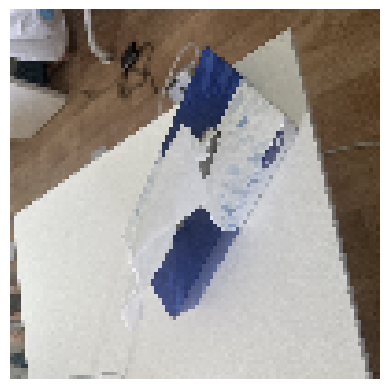

In [148]:
vgg_hpt_predict_func("/content/drive/MyDrive/load_image_test_model/IMG_8443.JPG", VGG_model)

In [ ]:
vgg_hpt_predict_func("", VGG_model)